In [414]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import nltk
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

Read the data from csv file

In [415]:
train = pd.read_csv("C:/Users/USER/OneDrive/Documents/AI UTM/AA/Lyrics Classifier/Song_Dataset.csv", encoding= 'unicode_escape')

Show the dataset

In [416]:
train

,Type,Title,Song
0,M,2 X 4,"I¡¯m gonna make you, shake you, take you I¡¯m ..."
1,M,Ain't My Bitch,Outta my way Outta my day Out of your mind and...
2,M,All Nightmare Long,Luck. Runs. Out. Crawl from the wreckage one m...
3,M,All Within My Hands,"All within my hands Squeeze it in, crush it do..."
4,M,Am I Evil?,"My mother was a witch, she was burned alive. T..."
...,...,...,...
201,N,Son of a Gun,"Up, up, up and down Turn, turn, turn around Ro..."
202,N,Spank Thru,And as the soft pretentious mountains Glisten ...
203,N,Stain,Well he never bleeds and he never fucks And he...
204,N,Stay Away,"Monkey see, monkey do (I don't know why) Rathe..."


Randomized the order of the dataset

In [417]:
final = train.sample(frac = 1)

In [418]:
final

,Type,Title,Song
198,N,Sliver,When Mom and Dad went to a show They dropped m...
203,N,Stain,Well he never bleeds and he never fucks And he...
186,N,Plateau,Many a hand has scaled the grand old face of t...
8,M,"Atlas, Rise!",Bitterness and burden Curses rest on thee Soli...
144,N,Dive,"Pick me, pick me, yeah Let a low long signal A..."
...,...,...,...
75,M,Loverman,There's a devil waiting outside your door (How...
130,N,Aneurysm,"Come on over, do the twist, aha Overdo it and ..."
135,N,Big Cheese,"Big cheese, make me Mine says, go to the offic..."
105,M,Remember Tomorrow,"Unchain the colours before my eyes, Yesterday'..."


Convert the label of "M" to 1 and label of "N" to 0. This is because the plotting of ROC graph cannot interpret the label of "M" and "N"

In [419]:
def partistion(x):
    if x == 'M':
        return 1
    else :
       return 0

In [420]:
ActualLabel = final['Type']
PositiveNegative = ActualLabel.map(partistion)
final['Type'] = PositiveNegative

final.shape
final

,Type,Title,Song
198,0,Sliver,When Mom and Dad went to a show They dropped m...
203,0,Stain,Well he never bleeds and he never fucks And he...
186,0,Plateau,Many a hand has scaled the grand old face of t...
8,1,"Atlas, Rise!",Bitterness and burden Curses rest on thee Soli...
144,0,Dive,"Pick me, pick me, yeah Let a low long signal A..."
...,...,...,...
75,1,Loverman,There's a devil waiting outside your door (How...
130,0,Aneurysm,"Come on over, do the twist, aha Overdo it and ..."
135,0,Big Cheese,"Big cheese, make me Mine says, go to the offic..."
105,1,Remember Tomorrow,"Unchain the colours before my eyes, Yesterday'..."


Text Processing is carried out, which includes convert letters into lowercase, removing the stop words, numbers, punctuation and white spaces, and stemming 

In [421]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemming

def cleanpunc(sentence): #function to clean the word of any punctuation
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [422]:
i = 0
str1 = ' '
final_string = []
all_M_words = [] #store words from +ve reviews here
all_N_words = [] #store words from -ve reviews here
s = ''
for sent in final['Song'].values:
    filtered_sentence=[]
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Type'].values)[i]==1:
                        all_M_words.append(s) #list of all words that are positve
                    if (final['Type'].values)[i]==0:
                        all_N_words.append(s) #list of all words that are negative
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i +=1

After clean the lyrics, store the cleaned lyrics into column of "CleanedText"

In [423]:
final['CleanedText']=final_string

In [424]:
final

,Type,Title,Song,CleanedText
198,0,Sliver,When Mom and Dad went to a show They dropped m...,b'mom dad went show drop grandpa joe kick scre...
203,0,Stain,Well he never bleeds and he never fucks And he...,b'well never bleed never fuck never leav caus ...
186,0,Plateau,Many a hand has scaled the grand old face of t...,b'mani hand scale grand old face plateau belon...
8,1,"Atlas, Rise!",Bitterness and burden Curses rest on thee Soli...,b'bitter burden curs rest thee solitair sorrow...
144,0,Dive,"Pick me, pick me, yeah Let a low long signal A...",b'pick pick yeah let low long signal eas least...
...,...,...,...,...
75,1,Loverman,There's a devil waiting outside your door (How...,b'there devil wait outsid door much longer the...
130,0,Aneurysm,"Come on over, do the twist, aha Overdo it and ...",b'come twist aha overdo fit aha love much make...
135,0,Big Cheese,"Big cheese, make me Mine says, go to the offic...",b'big chees make mine say offic big chees make...
105,1,Remember Tomorrow,"Unchain the colours before my eyes, Yesterday'...",b'unchain colour eye yesterday sorrow tomorrow...


In [425]:
freq_dist_M = nltk.FreqDist(all_M_words)
freq_dist_N = nltk.FreqDist(all_N_words)

print("Most Common Metallica words : ",freq_dist_M.most_common(20))
print("Most Common Nirvana Words : ",freq_dist_N.most_common(20))

Most Common Metallica words :  [(b'see', 151), (b'never', 127), (b'away', 122), (b'take', 119), (b'time', 118), (b'life', 111), (b'come', 111), (b'dont', 110), (b'one', 104), (b'feel', 103), (b'die', 97), (b'way', 95), (b'kill', 93), (b'let', 93), (b'want', 91), (b'make', 89), (b'back', 88), (b'know', 83), (b'say', 81), (b'like', 81)]
Most Common Nirvana Words :  [(b'dont', 158), (b'like', 95), (b'yeah', 92), (b'take', 85), (b'come', 66), (b'know', 65), (b'got', 63), (b'away', 61), (b'think', 58), (b'aint', 57), (b'said', 55), (b'get', 55), (b'girl', 55), (b'your', 54), (b'one', 53), (b'ever', 52), (b'home', 49), (b'shame', 45), (b'gonna', 45), (b'back', 44)]


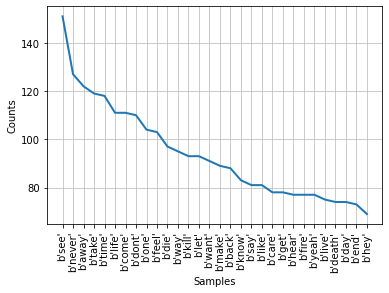

In [426]:
import matplotlib.pyplot as plt
freq_dist_M.plot(30,cumulative=False)
plt.show()

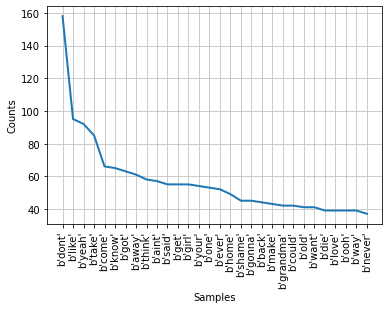

In [427]:
import matplotlib.pyplot as plt
freq_dist_N.plot(30,cumulative=False)
plt.show()

Feature extraction by using Bag of words

In [428]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['CleanedText'].values.tolist())

In [429]:
count_vect.vocabulary_

{'mom': 1599,
 'dad': 571,
 'went': 2798,
 'show': 2232,
 'drop': 735,
 'grandpa': 1065,
 'joe': 1327,
 'kick': 1352,
 'scream': 2149,
 'said': 2110,
 'pleas': 1858,
 'dont': 705,
 'grandma': 1064,
 'take': 2510,
 'home': 1190,
 'eat': 756,
 'dinner': 665,
 'mash': 1523,
 'potato': 1879,
 'stuff': 2440,
 'like': 1443,
 'couldnt': 506,
 'chew': 391,
 'meat': 1543,
 'good': 1052,
 'stop': 2408,
 'cri': 536,
 'outsid': 1756,
 'ride': 2070,
 'bike': 213,
 'that': 2546,
 'kill': 1354,
 'toe': 2602,
 'well': 2797,
 'ice': 1235,
 'cream': 528,
 'fell': 867,
 'asleep': 132,
 'watch': 2780,
 'woke': 2840,
 'mother': 1618,
 'arm': 116,
 'wanna': 2767,
 'alon': 65,
 'never': 1669,
 'bleed': 237,
 'fuck': 979,
 'leav': 1406,
 'caus': 361,
 'hes': 1170,
 'got': 1057,
 'bad': 158,
 'luck': 1485,
 'read': 1986,
 'draw': 721,
 'sleep': 2272,
 'yeah': 2871,
 'stain': 2367,
 'mani': 1507,
 'hand': 1116,
 'scale': 2133,
 'grand': 1063,
 'old': 1727,
 'face': 830,
 'plateau': 1853,
 'belong': 199,
 'stran

In [430]:
count_vect.transform(final['CleanedText'].values).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

There are 206 row of data with 2889 features in the final dataset

In [431]:
final_counts.shape

(206, 2889)

Splitting the dataset into training set and testing set with the ratio of 0.8 to training set and 0.2 to testing set.

In [432]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    final_counts, final['Type'], test_size=0.2, random_state=1)

generate a no skill prediction for the ROC graph

In [433]:
ns_probs = [0 for _ in range(len(y_test))]

In [434]:
X_train

<164x2889 sparse matrix of type '<class 'numpy.int64'>'
	with 8257 stored elements in Compressed Sparse Row format>

Naive Bayes Classification model

In [435]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.8809523809523809


Evaluation with Confuncion Matrix and ROC graph

In [436]:
print(metrics.classification_report(y_test, predicted, digits=6))

              precision    recall  f1-score   support

           0   0.882353  0.833333  0.857143        18
           1   0.880000  0.916667  0.897959        24

    accuracy                       0.880952        42
   macro avg   0.881176  0.875000  0.877551        42
weighted avg   0.881008  0.880952  0.880466        42



confusion matric follow as: 
[[TN FP]
 [FN TP]]

In [437]:
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, predicted))

Confusion matrix:
[[15  3]
 [ 2 22]]


predict probabilities and keep probabilities for the positive outcome only

In [438]:
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

calculate scores

In [439]:
from sklearn.metrics import roc_auc_score
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

summarize scores and printing the value of area under curve 

In [440]:
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.921


calculate ROC curves

In [441]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

Plot ROC graph

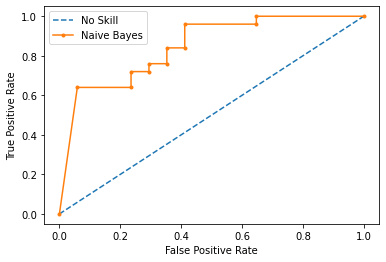

In [413]:
from matplotlib import pyplot
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Naive Bayes')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()